<a href="https://colab.research.google.com/github/mdehghani86/RL_labs/blob/master/Lab%202/Lab_2(b)_MABs_Nonstationary_SampleAverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Lab Logo](https://github.com/mdehghani86/RL_labs/blob/master/Lab%202/2_Lab_MAB_Logo.png?raw=true)

# **Lab 2-b: Multi-Armed Bandits Problem**  
### 🎰 *Nonstationary with Sample Average*

---

## 1 ▸ **Introduction**

Reinforcement learning problems are often **nonstationary**, meaning the true values change over time.  
In such cases it makes sense to give more weight to **recent rewards** than to long-past rewards.  
We need a slight modification to transform the stationary bandit problem into a **non-stationary** one.

---

### 📐 **Mathematical Setup**  

The true value $q_*(a)$ of each of the ten actions is sampled from a normal distribution with mean **0** and variance **1** (*Gaussian Distribution*).  
The actual rewards are then selected according to a mean $q_*(a)$ unit variance normal distribution.

$$
q_*(a) \sim \mathcal{N}(0, 1)
$$

$$
R_t \sim \mathcal{N}(q_*(a), 1)
$$

---

## 2 ▸ **Calculating and Displaying True Reward Values: Gaussian Distribution**

For the **nonstationary rewards**, we vary the expected action value by a small variation over time.

We use a modified version of the **10-armed testbed** in which all the $q(a)$ start out equal and then take independent random walks,  
by adding a normally distributed increment with mean $0$ and standard deviation $0.01$ to all the $q(a)$ on each step.

$$
q_t(a) = q_{t-1}(a) + \mathcal{N}(0, 0.01^2)
$$

 The true value $q_{*}(a)$ of each of the ten actions is selected according to a normal distribution with mean zero and unit variance `(Gaussian Distribution)`, and then the actual rewards were selected according to a mean $q_{*}(a)$ unit variance normal distribution.

Random-state object: RandomState(MT19937)
Expected action values: [ 0.08680988 -0.44326123 -0.15096482  0.68955226 -0.99056229 -0.75686176
  0.34149817  0.65170551 -0.72658682  0.15018666]
Mean: -0.11484844282561713


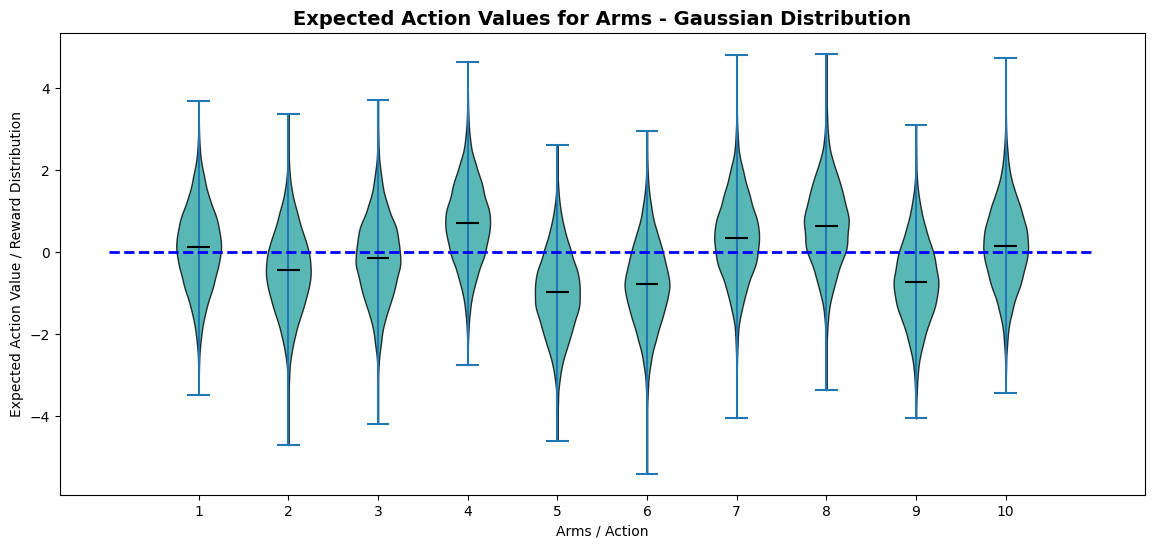

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Setup: Bandit Parameters
# ----------------------------
arms = 10  # number of arms in the bandit problem
rs = np.random.RandomState(seed=100)  # random-state object for reproducibility

# ----------------------------
# Generate Expected Action Values
# ----------------------------
# Each arm's expected reward value is drawn uniformly from [-1, 1]
expected_action_value = rs.uniform(-1, 1, arms)

# Calculate and print the mean of the expected values (should be ~0)
print("Random-state object: {}\nExpected action values: {}\nMean: {}".format(
    rs, expected_action_value, np.mean(expected_action_value)
))

# ----------------------------
# Generate Reward Distributions
# ----------------------------
# The true value q*(a) of each of the ten actions follows a Gaussian distribution:
# - mean = expected_action_value for that arm
# - standard deviation = 1
Qa = expected_action_value + np.random.normal(scale=1, size=(10000, arms))

# ----------------------------
# Visualization: Violin Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Create violin plot for the 10 arms
parts = ax.violinplot(Qa, showmeans=False, showmedians=True)

# Apply Sutto-inspired teal color to the violins
for pc in parts['bodies']:
    pc.set_facecolor("#2fa5a3")   # teal fill
    pc.set_edgecolor("black")     # black outline
    pc.set_alpha(0.8)             # transparency

# Style the median line inside violins
if 'cmedians' in parts:
    parts['cmedians'].set_color("black")
    parts['cmedians'].set_linewidth(1.5)

# ----------------------------
# Customize Axes
# ----------------------------
x_pos = range(1, arms + 1)
plt.xticks(x_pos)  # label each arm on the x-axis

# Add horizontal baseline at y=0 for reference
plt.plot([0, len(x_pos) + 1], [0, 0], 'b--', lw=2)

# Labels and title
ax.set_title("Expected Action Values for Arms - Gaussian Distribution", fontsize=14, fontweight="bold")
ax.set_xlabel("Arms / Action")
ax.set_ylabel("Expected Action Value / Reward Distribution")

plt.show()


# 2 ▸ Problem Definition

---

### 🎯 **Expected Initial Action Value** ($\mu$)

We initialize the **true values** for each arm of the bandit problem.  
For $k$ arms, the action values are sampled from a uniform distribution:

$$
q(a) \sim \mathrm{Uniform}(-1, 1), \quad a = 1, 2, \ldots, k
$$

---

### 🌪️ **Adding Randomness: Non-Stationary Case**

In a **non-stationary environment**, the action values drift over time.  
At each step, we update them with a small Gaussian increment:

$$
q(a) \leftarrow q(a) + \mathcal{N}(0, \sigma^2), \quad \sigma = 0.01
$$

This models a **random walk** of the mean values.

---

### 💡 **Reward Function**

When an action $a$ is chosen, the observed reward is drawn from a normal distribution:

$$
R_t \sim \mathcal{N}\big(q(a), 1\big)
$$

That is, the **mean reward** equals the current action value $q(a)$,  
with **variance fixed at 1**.

In [14]:
# Generates initial true values q(a) for all arms.
# q(a) ~ Uniform(-1, 1)
def expected_action_value_function(mu=0, scale=1, arms=10):
    expected_action_value = np.random.uniform(-1, 1, arms)  # centered around 0
    return expected_action_value

# Non-stationary update: apply a small Gaussian random walk to every q(a).
# This models drifting means over time (σ = 0.01).
def update_expected_action_value(expected_action_value):
    expected_action_value += np.random.normal(0, 0.01, arms)  # elementwise update
    return expected_action_value

# Reward sampler: returns a single reward for the chosen action.
# R ~ N(q(a), 1). 'scale' is the std of observation noise (default 1).
def reward_function(action_taken, expected_action_value, scale=1):
    reward = expected_action_value[action_taken] + np.random.normal(scale=scale)
    return reward


## 3 ▸ **Solution Approach**

### Method 1: **$\epsilon$-greedy Function**

The $\epsilon$-greedy algorithm balances **exploration** and **exploitation**:

- With probability $(1 - \epsilon)$ → **Exploit**: Choose the best action based on current estimates
- With probability $\epsilon$ → **Explore**: Choose a random action to gather more information

---

In [15]:
# Define the e-greedy funtion
def e_greedy(estimate_action_value,e,arms):
    # genereate a random num (0,1) to be compared with epsilon
    e_estimator = np.random.uniform(0, 1)
    # epsilon-greedy appraoch
    action = np.argmax(estimate_action_value) if e_estimator > e else np.random.choice(np.arange(arms))
    return action

### Action Value estimation-  <span style="color:blue">Method 1: Sample Average approach</span>

---




In [16]:
# Define estimate_action_value function (using sample average method)
def sample_average (estimate_action_value, action, reward, count):
    estimate_action_value[action] = estimate_action_value[action] + (1/(count[action]+1))\
        * (reward - estimate_action_value[action])
    return estimate_action_value

### The k-armed bandit problem

---

In [17]:
def multi_arm_bandit_problem(arms = 10, steps = 1000, e = 0.1, expected_action_value = [],scale=1 ):
    """
    Simulates a non-stationary multi-armed bandit problem using ε-greedy strategy.
    Returns rewards
    """
    # Initilization
    overall_reward, optimal_action = [], []

    # Initial Action values is set to zero
    estimate_action_value = np.zeros(arms)

    #number of times is action (arm) is taken
    count = np.zeros(arms)

    # Main loop
    for s in range(0, steps):

        # Select an action
        action=e_greedy(estimate_action_value,e, arms)

        # Adding randomness to the action value for each bandit problem,
        # thus simulating variable rewards over time. This segment makes a stationary
        # reward system, non-stationary.
        expected_action_value = update_expected_action_value(expected_action_value)

        # Observe the reward for the selected Action
        reward = reward_function(action, expected_action_value,scale)

        # Update Estimates of Action Value for the selected Action based on its observed Reward
        estimate_action_value=sample_average(estimate_action_value, action, reward, count)

        # Update rewards' list
        overall_reward.append(reward)

        # If the optimal action is taken
        optimal_action.append(action == np.argmax(expected_action_value))

        # Increment the number of times the selected action is takern
        count[action] += 1

    return overall_reward, optimal_action

### Multi-arm testbed

---


In [18]:
# The k-armed bandits testbed
def run_game(epsilon, runs = 5000, steps = 1000, mu=0, scale=1, arms = 10):
    rewards = np.zeros((runs, steps))
    optimal_actions = np.zeros((runs, steps))
    expected_action_value = expected_action_value_function(mu=mu, scale=scale , arms=arms)
    # Replicate each expreiment
    for run in range(0, runs):
        rewards[run][:], optimal_actions[run][:] = multi_arm_bandit_problem(arms = arms,
                                                                            steps = steps,
                                                                            e = epsilon,
                                                                            expected_action_value = expected_action_value,
                                                                            scale=scale)
    rewards_avg = np.average(rewards, axis = 0)
    optimal_action_perc = np.average(optimal_actions, axis = 0)
    return(rewards_avg, optimal_action_perc)

### Plotting the reward performance and optimal action percentage of the agents with different epsilon values.


---

In [19]:
# Number of arms of bandits.
arms=10

# Numner of episodes in each run
steps = 1000

# Total number of runs
runs = 2000

# The list of corresponding epsilon values for both the plots
Epsilons=[0.0, 0.01, 0.1]

In [20]:
# Running the Experiment with different Epsilon Values
rewards_avg_by_epsilon = dict()
optimal_action_perc_by_epsilon = dict()
for epsilon in Epsilons:
    print('Running for epsilon {}'.format(epsilon))
    rewards_avg, optimal_action_perc = run_game(epsilon, runs=runs, steps=steps, arms=arms)
    rewards_avg_by_epsilon[epsilon] = rewards_avg
    optimal_action_perc_by_epsilon[epsilon] = optimal_action_perc

print('Experiment is complete')

Running for epsilon 0.0
Running for epsilon 0.01
Running for epsilon 0.1
Experiment is complete


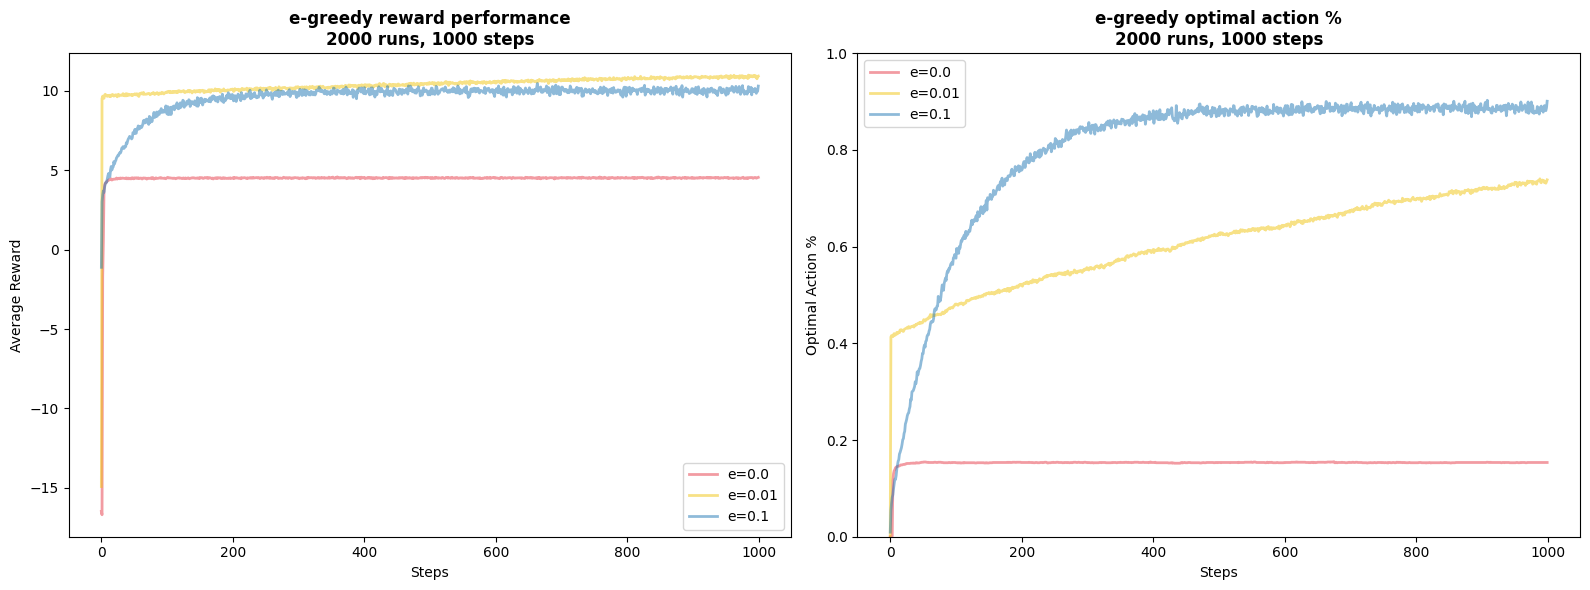

In [21]:
# Colors taken from the image (red, yellow, blue, orange, black)
plot_colors = ["#e63946", "#f1c40f", "#1f77b4", "#f06d3d", "#000000"]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Average Reward ---
for i, epsilon in enumerate(Epsilons):
    axes[0].plot(
        range(steps),
        rewards_avg_by_epsilon[epsilon],
        label=f"e={epsilon}",
        color=plot_colors[i % len(plot_colors)],
        linewidth=2,
        alpha=0.5  # 50% transparent
    )

axes[0].legend(loc='lower right')
axes[0].set_title(f'e-greedy reward performance\n{runs} runs, {steps} steps', fontsize=12, fontweight="bold")
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Average Reward')

# --- Right: Optimal Action % ---
for i, epsilon in enumerate(Epsilons):
    axes[1].plot(
        range(steps),
        optimal_action_perc_by_epsilon[epsilon],
        label=f"e={epsilon}",
        color=plot_colors[i % len(plot_colors)],
        linewidth=2,
        alpha=0.5  # 50% transparent
    )

axes[1].legend()
axes[1].set_title(f'e-greedy optimal action %\n{runs} runs, {steps} steps', fontsize=12, fontweight="bold")
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Optimal Action %')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


---

## 📊 **Conclusion**

In this lab, we explored the **non-stationary multi-armed bandit problem** where reward distributions change over time.

Key takeaways:
- The **$\epsilon$-greedy** strategy balances exploration vs exploitation
- **Sample averaging** helps estimate action values from observed rewards  
- **Non-stationary environments** require continuous adaptation as optimal actions drift

This forms the foundation for understanding more complex reinforcement learning algorithms that must adapt to changing environments.

---

✅ **Lab 2-b Complete!**